In [1]:
import os
import shutil

import kaggle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
import datetime
import math
import warnings

import numpy as np
import pandas as pd
import prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore")

In [2]:
os.makedirs("datasets", exist_ok=True)

if "AAPL.csv" not in os.listdir("datasets"):
    kaggle.api.dataset_download_files("suyashlakhani/apple-stock-prices-20152020")
    shutil.unpack_archive("apple-stock-prices-20152020.zip", extract_dir="datasets/")
    os.remove("apple-stock-prices-20152020.zip")

### EDA

In [3]:
df = pd.read_csv("datasets/AAPL.csv", index_col=0)
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,AAPL,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000,316.500000,310.324100,313.170000,33843125,0.0,1.0
1254,AAPL,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000,318.520000,313.010000,315.030000,25432385,0.0,1.0
1255,AAPL,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000,319.520000,316.200000,316.680000,27876215,0.0,1.0
1256,AAPL,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000,320.890000,315.870000,318.660000,25672211,0.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 147.4+ KB


In [5]:
df.size

17612

In [6]:
df.shape

(1258, 14)

In [7]:
df.isnull().sum()

symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

In [8]:
df.symbol.value_counts()

symbol
AAPL    1258
Name: count, dtype: int64

In [9]:
df.rename(columns={"date": "Date", "close": "Value"}, inplace=True)
df

,symbol,Date,Value,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.0500,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.1000,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.9000,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.0500,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.3200,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,AAPL,2020-05-18 00:00:00+00:00,314.960,316.500,310.3241,313.17,33843125,314.960000,316.500000,310.324100,313.170000,33843125,0.0,1.0
1254,AAPL,2020-05-19 00:00:00+00:00,313.140,318.520,313.0100,315.03,25432385,313.140000,318.520000,313.010000,315.030000,25432385,0.0,1.0
1255,AAPL,2020-05-20 00:00:00+00:00,319.230,319.520,316.2000,316.68,27876215,319.230000,319.520000,316.200000,316.680000,27876215,0.0,1.0
1256,AAPL,2020-05-21 00:00:00+00:00,316.850,320.890,315.8700,318.66,25672211,316.850000,320.890000,315.870000,318.660000,25672211,0.0,1.0


In [10]:
df_new = df[["Value"]]
df_new.head()

,Value
0,132.045
1,131.780
2,130.280
3,130.535
4,129.960


In [11]:
df_new["Date"] = pd.to_datetime(pd.to_datetime(df["Date"]).dt.date)
df_new.head()

,Value,Date
0,132.045,2015-05-27
1,131.780,2015-05-28
2,130.280,2015-05-29
3,130.535,2015-06-01
4,129.960,2015-06-02


In [12]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Value   1258 non-null   float64       
 1   Date    1258 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.5 KB


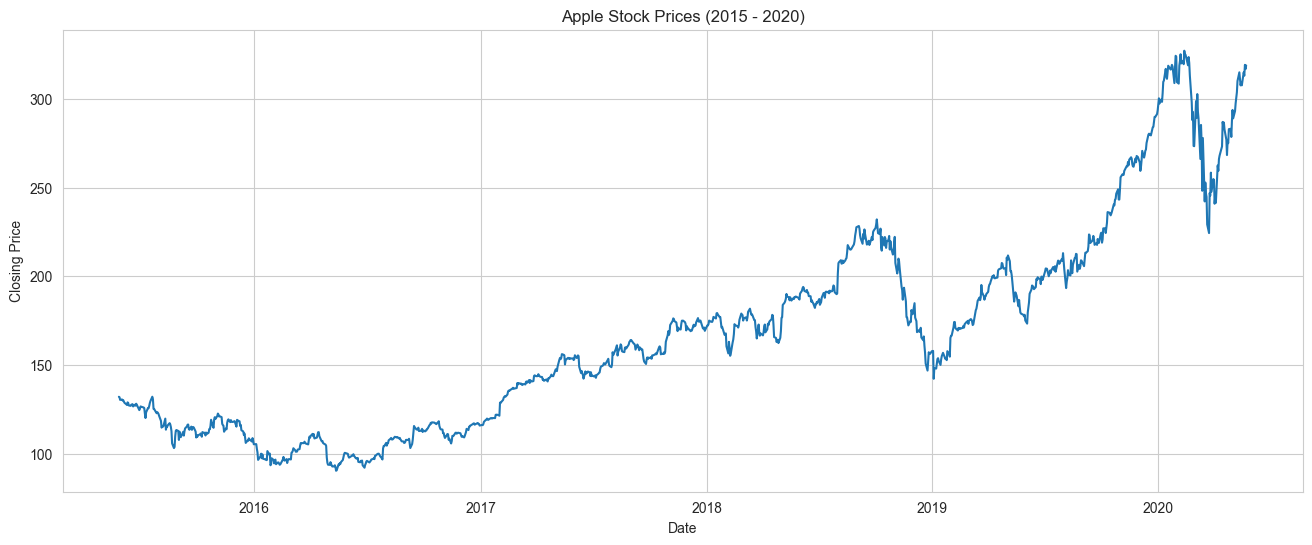

In [13]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_new, x="Date", y="Value")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Apple Stock Prices (2015 - 2020)")
plt.show()

# Forecating Models

### Prophet  Model

In [14]:
df_new_ = df_new.rename(mapper={"Date": "ds", "Value": "y"}, axis="columns")
df_new_.head()

,y,ds
0,132.045,2015-05-27
1,131.780,2015-05-28
2,130.280,2015-05-29
3,130.535,2015-06-01
4,129.960,2015-06-02


In [15]:
op = prophet.Prophet()
op.fit(df_new_)

15:07:14 - cmdstanpy - INFO - Chain [1] start processing
15:07:15 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
forecast = op.make_future_dataframe(periods=365)
forecast = op.predict(forecast)

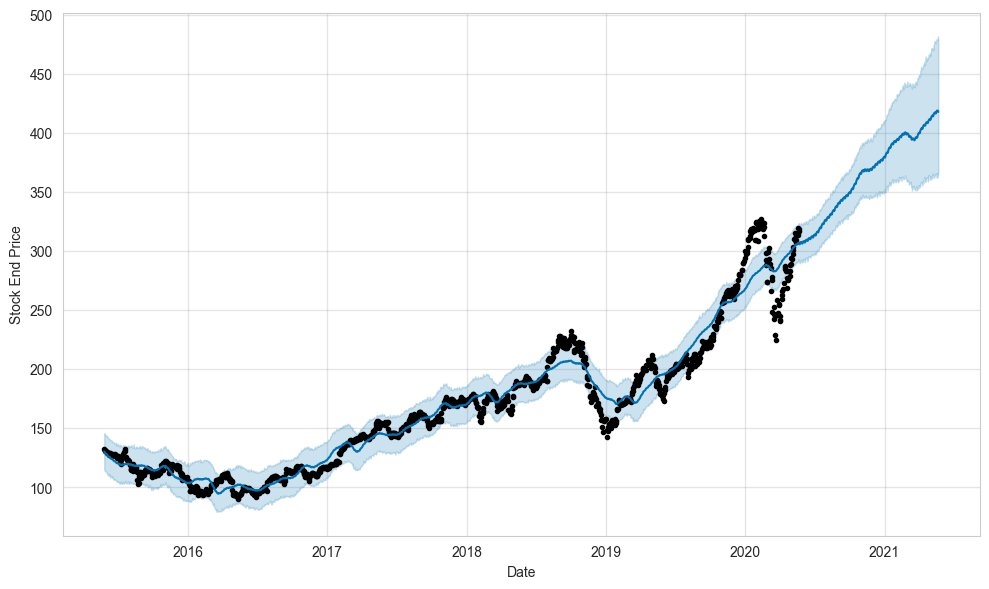

In [17]:
op.plot(forecast, xlabel="Date", ylabel="Stock End Price")
plt.show()

### ARIMA Model

In [18]:
df_new.shape

(1258, 2)

In [19]:
X_train = df_new[:1000]
X_test = df_new[1000:]

print("X_train Shape", X_train.shape)
print("X_test Shape", X_test.shape)

X_train Shape (1000, 2)
X_test Shape (258, 2)


In [20]:
X_train = X_train[["Date", "Value"]]
X_test = X_test[["Date", "Value"]]

X_train.set_index("Date", inplace=True)
X_test.set_index("Date", inplace=True)

In [21]:
index_9_months = pd.date_range(X_test.index[-1], freq="MS", periods=9)
index_9_months

DatetimeIndex(['2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01'],
              dtype='datetime64[ns]', freq='MS')

In [22]:
# P = 0.05
def define_d(data):
    X_train = adfuller(data, autolag="AIC")
    adf = X_train[0]
    pvalue = X_train[1]
    critical_value = X_train[4]["5%"]
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations",
        "Critical Value",
    ]
    for value, label in zip(X_train, labels):
        print(label + " : " + str(value))

    if pvalue < 0.05:
        print("** Data Is Stationary **")
    else:
        print("** Indicating It Is Non-Stationary **")


define_d(X_train)

ADF Test Statistic : -0.8012872716747917
p-value : 0.8187436488375897
#Lags Used : 8
Number of Observations : 991
Critical Value : {'1%': -3.4369658620871286, '5%': -2.8644609013346485, '10%': -2.56832523159495}
** Indicating It Is Non-Stationary **


In [23]:
data_diff = X_train.diff()
data_diff.dropna(inplace=True)
define_d(data_diff)

ADF Test Statistic : -10.58617965861
p-value : 6.707844077678938e-19
#Lags Used : 7
Number of Observations : 991
Critical Value : {'1%': -3.4369658620871286, '5%': -2.8644609013346485, '10%': -2.56832523159495}
** Data Is Stationary **


### Define p and q using PACF and ACF plot

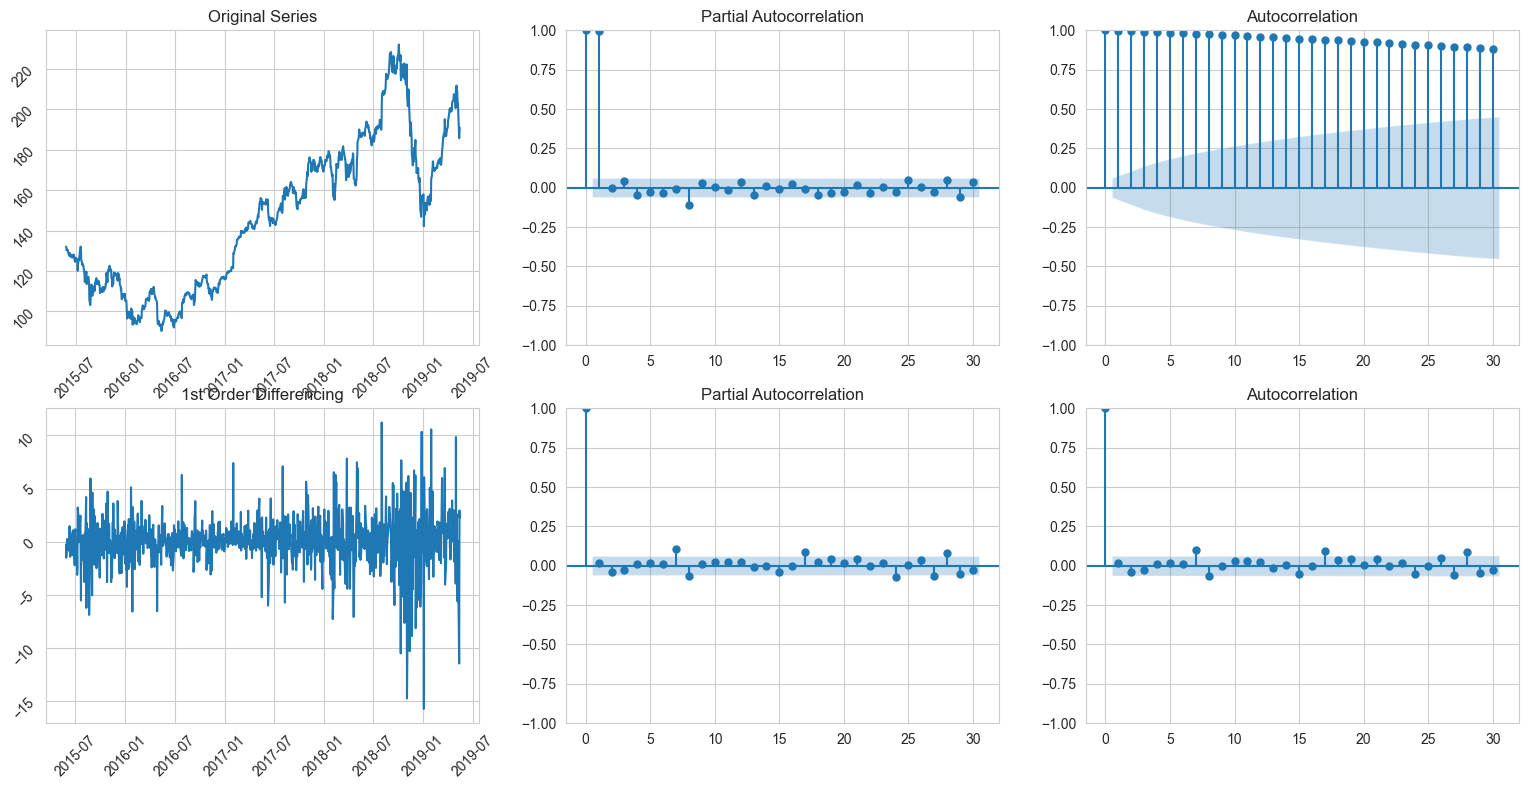

In [24]:
# Original Series
fig, axes = plt.subplots(2, 3)
fig.set_figheight(9)
fig.set_figwidth(19)
axes[0, 0].plot(X_train)
axes[0, 0].tick_params(labelrotation=45)
axes[0, 0].set_title("Original Series")
plot_pacf(X_train, ax=axes[0, 1])
plot_acf(X_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(X_train.diff())
axes[1, 0].set_title("1st Order Differencing")
axes[1, 0].tick_params(labelrotation=45)
plot_pacf(X_train.diff().dropna(), ax=axes[1, 1])
plot_acf(X_train.diff().dropna(), ax=axes[1, 2])

plt.show();

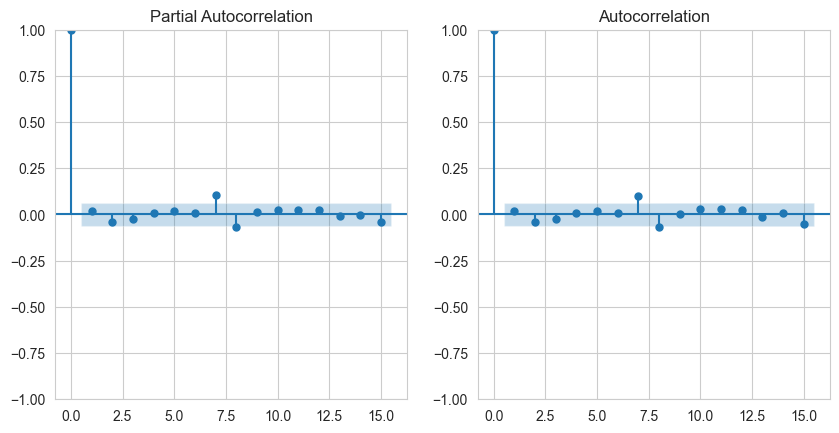

In [25]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
plot_pacf(X_train.diff().dropna(), lags=15, ax=ax[0])
plot_acf(X_train.diff().dropna(), lags=15, ax=ax[1])
plt.show()

In [26]:
price_validate = df_new["Value"][1000:]
price_validate

1000    190.08
1001    189.00
1002    183.09
1003    186.60
1004    182.78
         ...  
1253    314.96
1254    313.14
1255    319.23
1256    316.85
1257    318.89
Name: Value, Length: 258, dtype: float64

###  Calaculating error

In [27]:
def forecast_accuracy(forecast, actual):
    mape = (np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100).round(2)
    rmse = np.sqrt(((forecast - actual) ** 2).mean())
    return {"Mean Absolute Percentage Error (%)": mape, "Root Mean Squared Error": rmse}

### Model 1

In [28]:
model = ARIMA(X_train)
model = model.fit()
print(model.summary())

fc = model.forecast(258)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1000
Model:                          ARIMA   Log Likelihood               -5021.697
Date:                Wed, 25 Oct 2023   AIC                          10047.395
Time:                        15:07:18   BIC                          10057.210
Sample:                             0   HQIC                         10051.125
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        146.3985      1.231    118.912      0.000     143.985     148.811
sigma2      1347.0718     88.928     15.148      0.000    1172.776    1521.368
Ljung-Box (L1) (Q):                 997.04   Jarque-

{'Mean Absolute Percentage Error (%)': 39.67,
 'Root Mean Squared Error': 112.88859873181204}

### Model 2

In [29]:
model = ARIMA(X_train, order=(1, 0, 1))
model = model.fit()
print(model.summary())

fc = model.forecast(258)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2303.509
Date:                Wed, 25 Oct 2023   AIC                           4615.019
Time:                        15:07:18   BIC                           4634.650
Sample:                             0   HQIC                          4622.480
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        146.3986     55.446      2.640      0.008      37.726     255.071
ar.L1          0.9984      0.002    504.168      0.000       0.995       1.002
ma.L1          0.0193      0.022      0.864      0.3

{'Mean Absolute Percentage Error (%)': 24.96,
 'Root Mean Squared Error': 82.74550607394875}

### Model 3

In [30]:
model = ARIMA(X_train, order=(1, 1, 1))
model = model.fit()
print(model.summary())

fc = model.forecast(258)
forecast_accuracy(fc, price_validate.values)

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2297.919
Date:                Wed, 25 Oct 2023   AIC                           4601.837
Time:                        15:07:18   BIC                           4616.558
Sample:                             0   HQIC                          4607.432
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8601      0.121     -7.104      0.000      -1.097      -0.623
ma.L1          0.8861      0.109      8.136      0.000       0.673       1.100
sigma2         5.8273      0.133     43.798      0.0

{'Mean Absolute Percentage Error (%)': 21.96,
 'Root Mean Squared Error': 73.98155373967029}

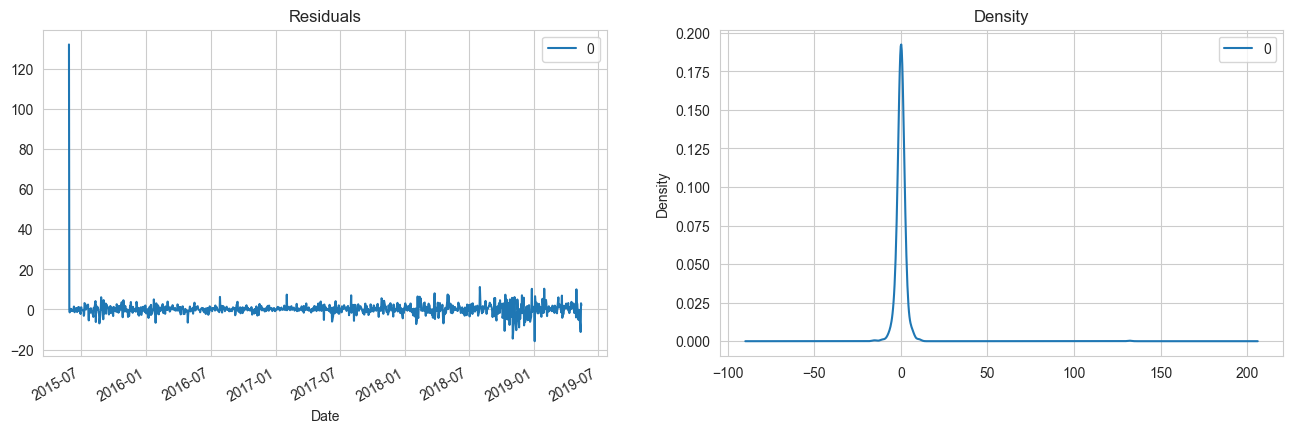

In [31]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(16)
residuals = pd.DataFrame(model.resid)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind="kde", title="Density", ax=ax[1])
plt.show()

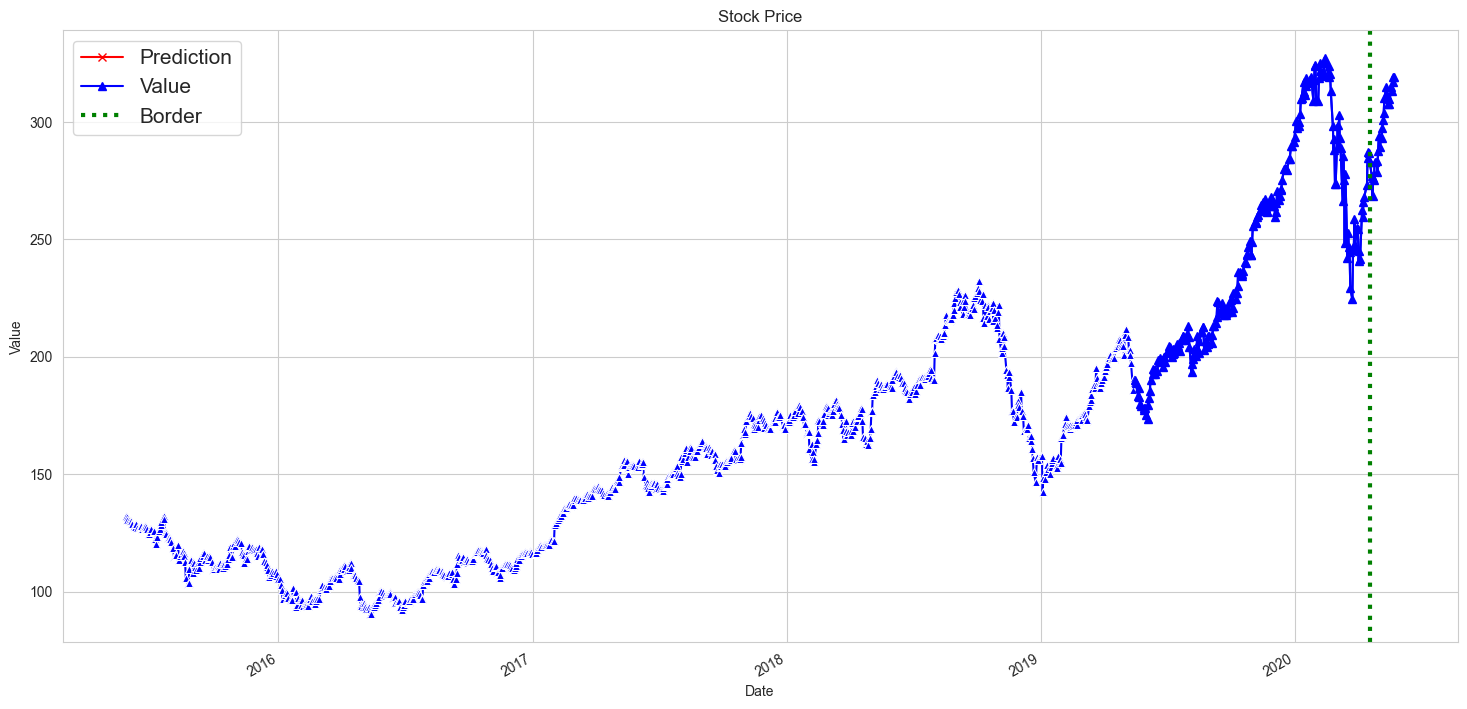

In [32]:
price_forecast = model.forecast(9)
price_forecast = pd.Series(price_forecast, index=index_9_months)
price_forecast = price_forecast.rename("Prediction")

fig, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(x="Date", y="Value", data=df_new, color="blue", marker="^")
price_forecast.plot(ax=ax, c="red", marker="x", label="Prediction")
X_test.plot(ax=ax, c="blue", marker="^")
plt.title("Stock Price")
ax.axvline(x=18370, ls=":", linewidth=3, c="green", label="Border")
plt.legend(loc=0, fontsize=15)
plt.show()

In [33]:
df = pd.DataFrame({"Predictions": model.forecast(9)})
df["date"] = index_9_months
df.set_index("date")

,Predictions
date,
2020-06-01,190.823484
2020-07-01,190.906498
2020-08-01,190.835097
2020-09-01,190.896509
2020-10-01,190.843688
2020-11-01,190.889120
2020-12-01,190.850044
2021-01-01,190.883653
2021-02-01,190.854746


### LSTM Model

In [34]:
x_train, y_train = X_train.index, X_train.Value
x_test, y_test = X_test.index, X_test.Value

print(x_train.shape), print(x_test.shape)

(1000,)
(258,)


(None, None)

In [35]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1,
)

Epoch 1/100
16/16 [==============================] - 9s 156ms/step - loss: 22749.5137 - val_loss: 64488.5977
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 22615.3047 - val_loss: 64081.1523
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 22195.2031 - val_loss: 62925.0820
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 21347.9883 - val_loss: 61234.1758
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 20458.0234 - val_loss: 59987.9297
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 19898.9785 - val_loss: 59249.3438
Epoch 7/100
16/16 [==============================] - 0s 12ms/step - loss: 19542.0586 - val_loss: 58710.0938
Epoch 8/100
16/16 [==============================] - 0s 11ms/step - loss: 19268.0098 - val_loss: 58270.0977
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: 19030.5176 - val_loss: 57865.1797
Epoch 10/100
16/16 [=======

In [38]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 3ms/step


In [39]:
math.sqrt(mean_squared_error(y_train, train_predict))

87.44515573622829

In [40]:
train_predict[:10]

array([[67.027176],
       [67.027176],
       [67.027176],
       [67.027176],
       [67.027176],
       [67.027176],
       [67.027176],
       [67.027176],
       [67.027176],
       [67.027176]], dtype=float32)